In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config inlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette = 'muted', font_scale=1.3)
RANDOM_SEED = 42

rcParams['figure.figsize'] = 22,19

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
filename = (r'E:\Tensorflow\finalyr_project\models\DatasetVer2.csv')
df = pd.read_csv(filename, parse_dates=['Timestamp'], index_col='Timestamp')
df.head()

,ID,Day_of_week,Car_count
Timestamp,,,
2020-09-23 00:00:00,1.0,0.0,2.0
2020-09-23 00:01:00,2.0,0.0,2.0
2020-09-23 00:02:00,3.0,0.0,2.0
2020-09-23 00:03:00,4.0,0.0,3.0
2020-09-23 00:04:00,5.0,0.0,3.0


In [3]:
df.index

DatetimeIndex(['2020-09-23 00:00:00', '2020-09-23 00:01:00',
               '2020-09-23 00:02:00', '2020-09-23 00:03:00',
               '2020-09-23 00:04:00', '2020-09-23 00:05:00',
               '2020-09-23 00:06:00', '2020-09-23 00:07:00',
               '2020-09-23 00:08:00', '2020-09-23 00:09:00',
               ...
               '2020-10-22 23:51:00', '2020-10-22 23:52:00',
               '2020-10-22 23:53:00', '2020-10-22 23:54:00',
               '2020-10-22 23:55:00', '2020-10-22 23:56:00',
               '2020-10-22 23:57:00', '2020-10-22 23:58:00',
               '2020-10-22 23:59:00', '2020-10-23 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=43201, freq=None)

In [4]:
df.columns

Index(['ID', 'Day_of_week', 'Car_count'], dtype='object')

In [5]:
df['minute'] = df.index.minute
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [6]:
df.head()

,ID,Day_of_week,Car_count,minute,hour,day_of_week,day_of_month,month
Timestamp,,,,,,,,
2020-09-23 00:00:00,1.0,0.0,2.0,0,0,2,23,9
2020-09-23 00:01:00,2.0,0.0,2.0,1,0,2,23,9
2020-09-23 00:02:00,3.0,0.0,2.0,2,0,2,23,9
2020-09-23 00:03:00,4.0,0.0,3.0,3,0,2,23,9
2020-09-23 00:04:00,5.0,0.0,3.0,4,0,2,23,9


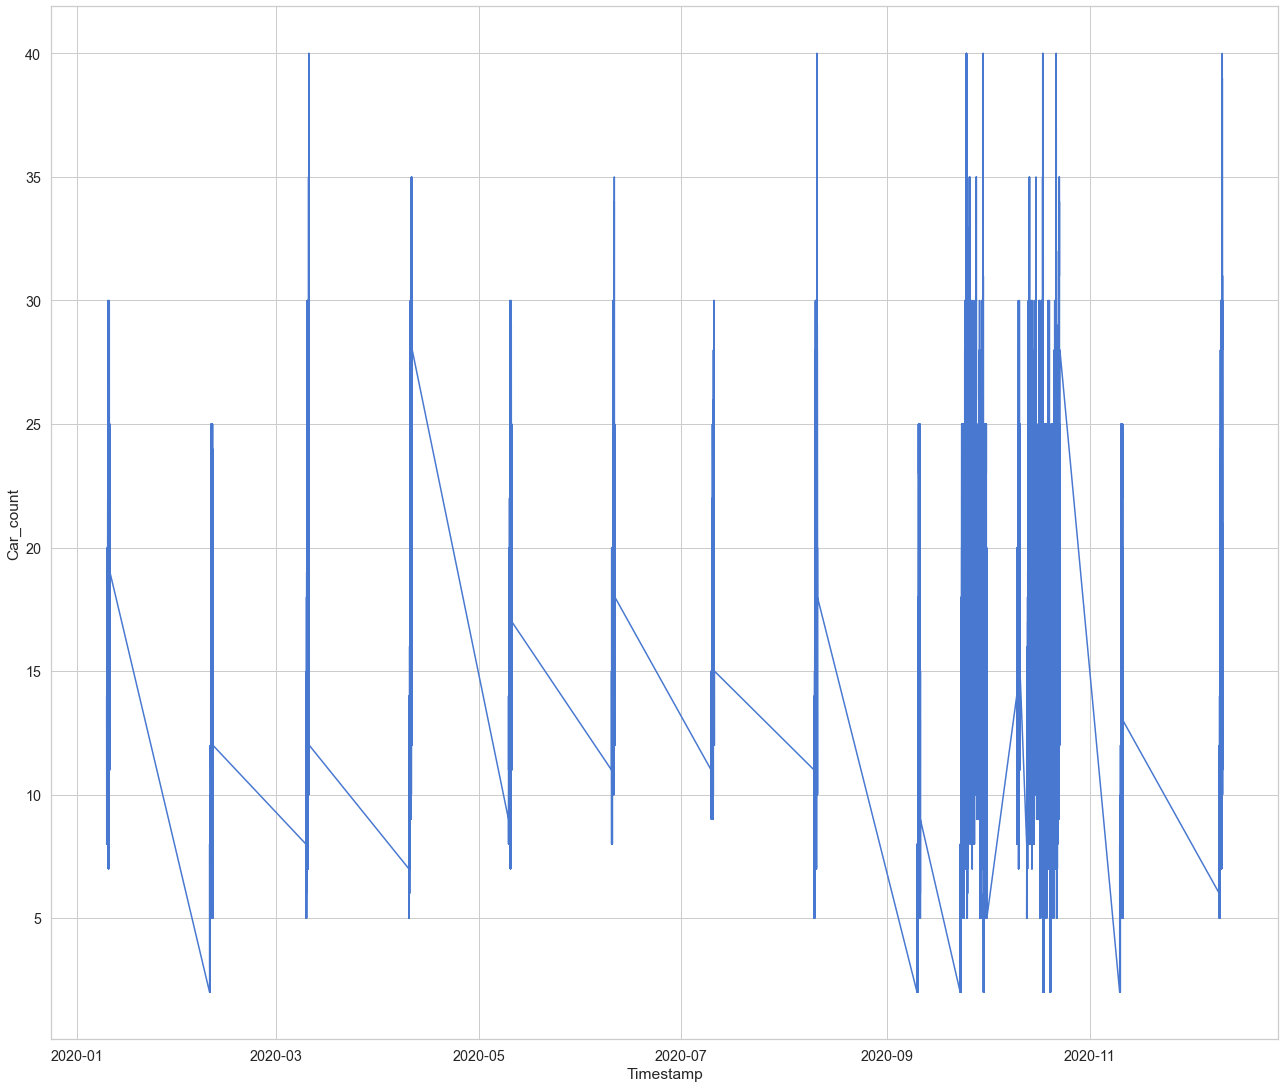

In [7]:
sns.lineplot(x=df.index, y='Car_count', data=df);

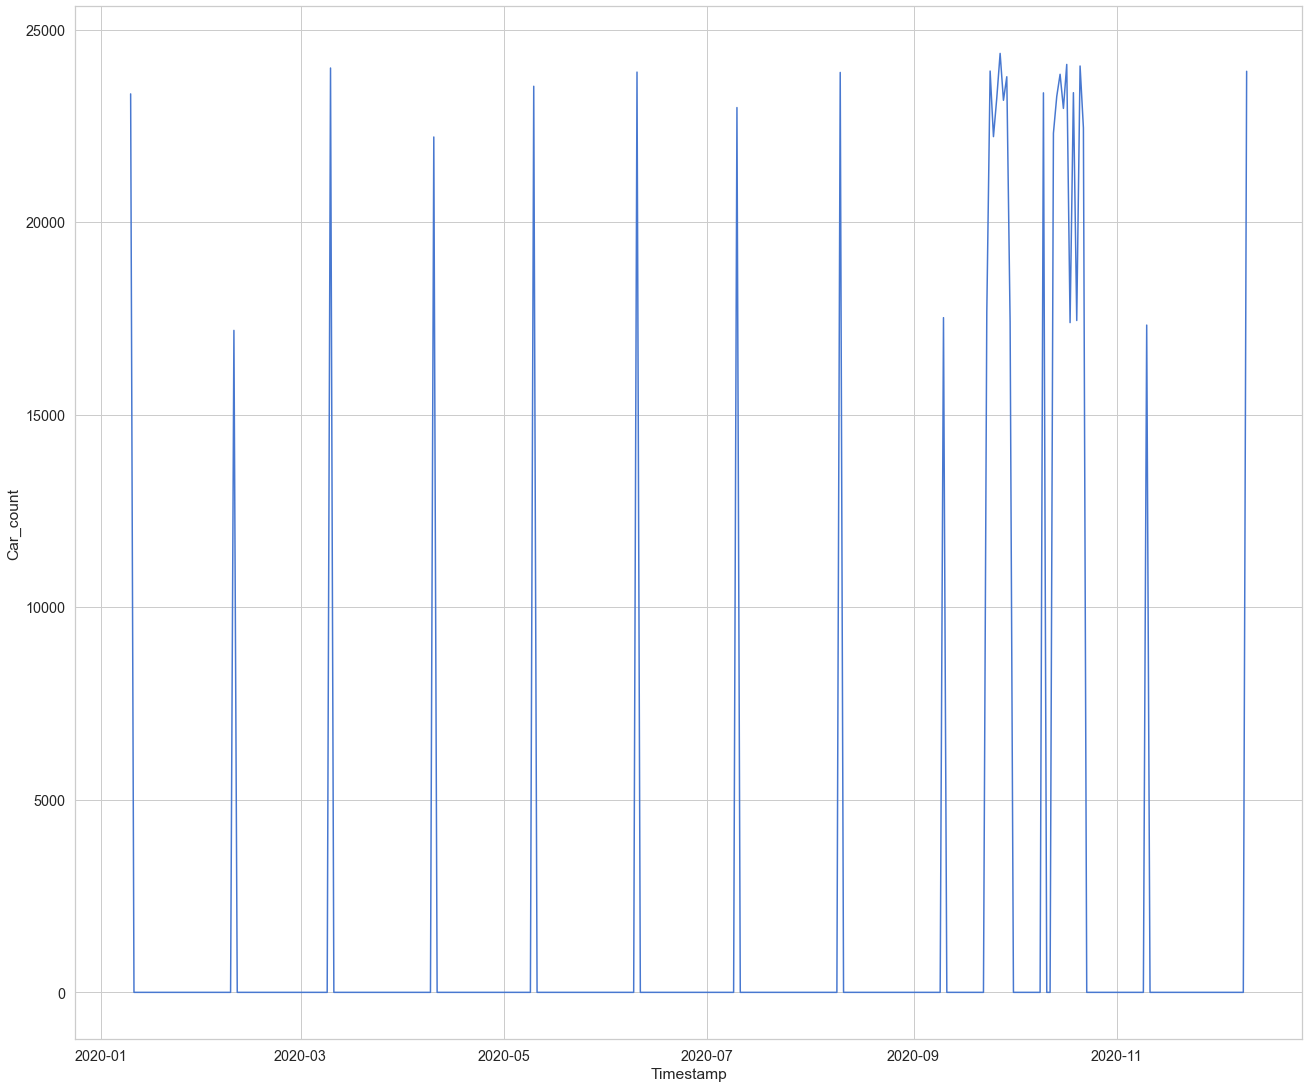

In [8]:
df_by_day = df.resample('D').sum()

sns.lineplot(x=df_by_day.index, y='Car_count', data=df_by_day);

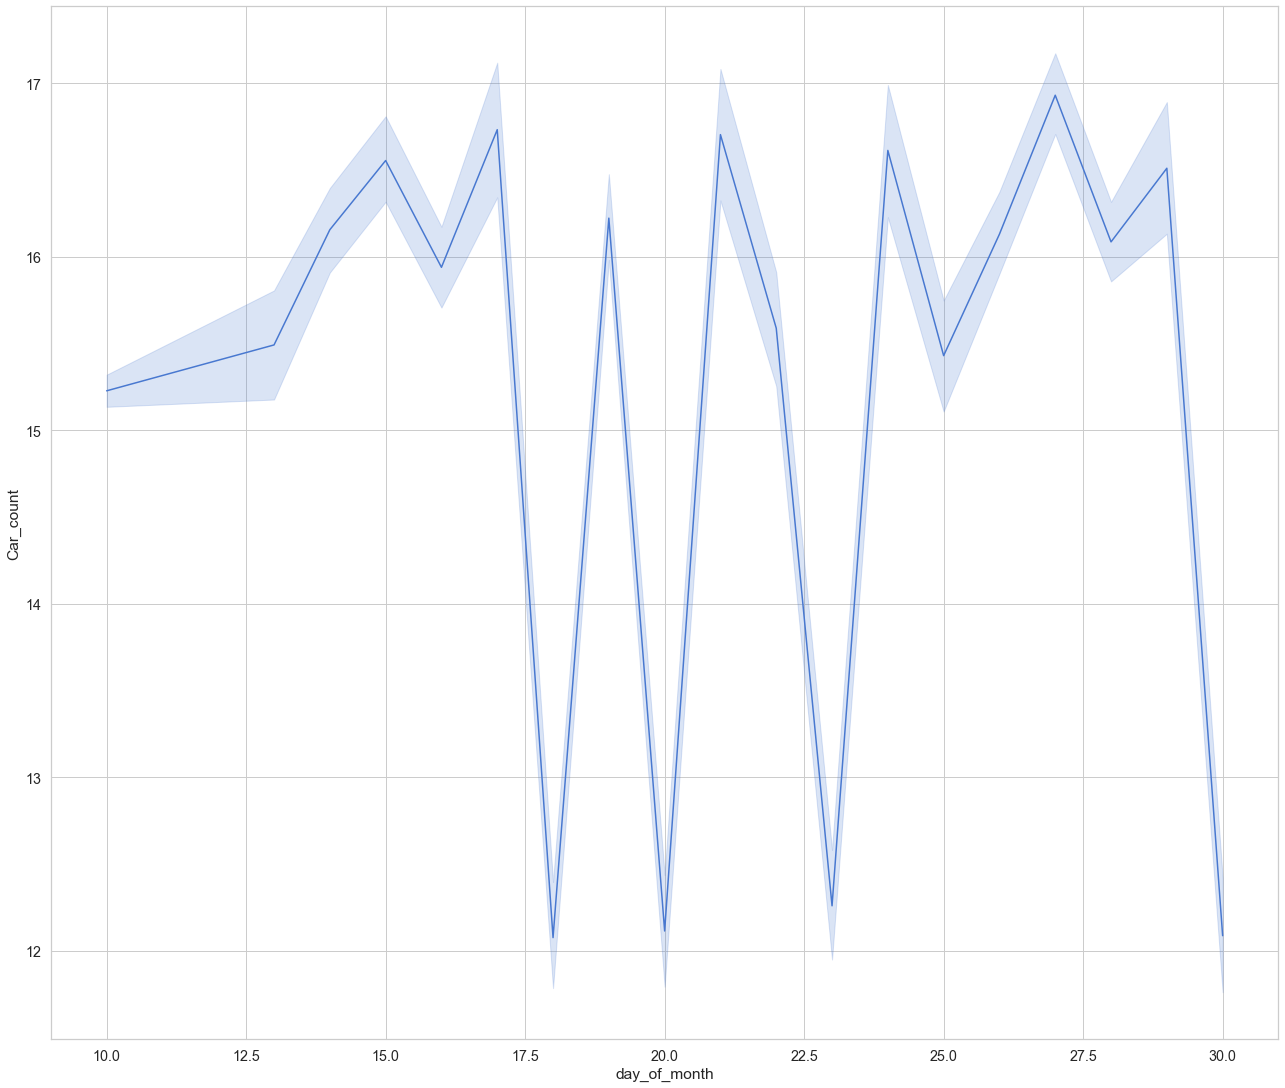

In [9]:
sns.lineplot(data=df, x='day_of_month', y='Car_count');

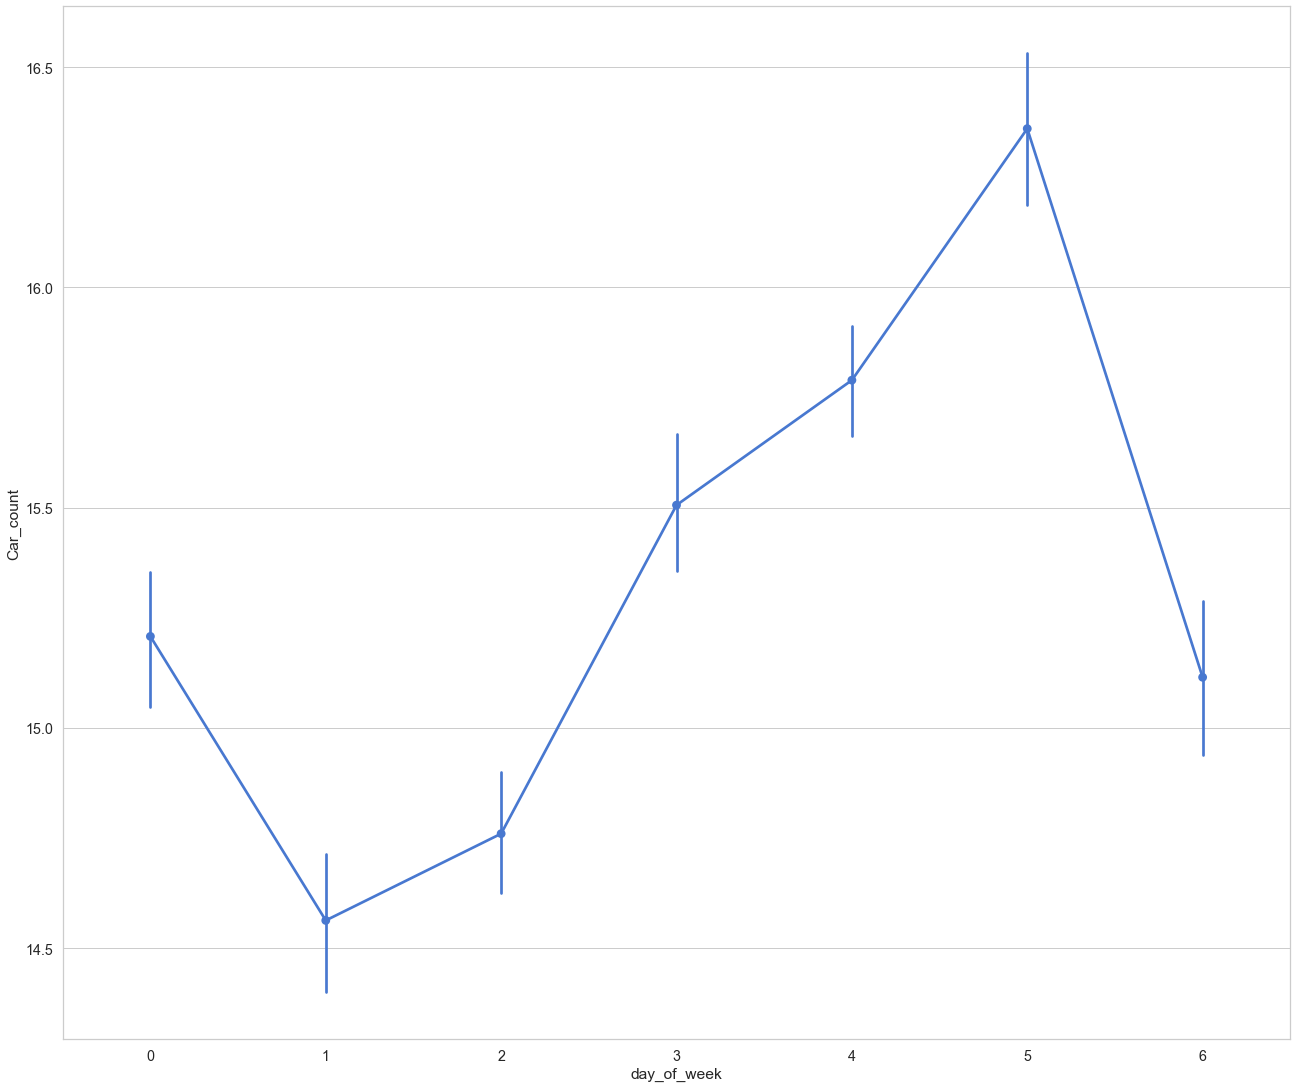

In [10]:
sns.pointplot(data=df, x='day_of_week', y='Car_count');

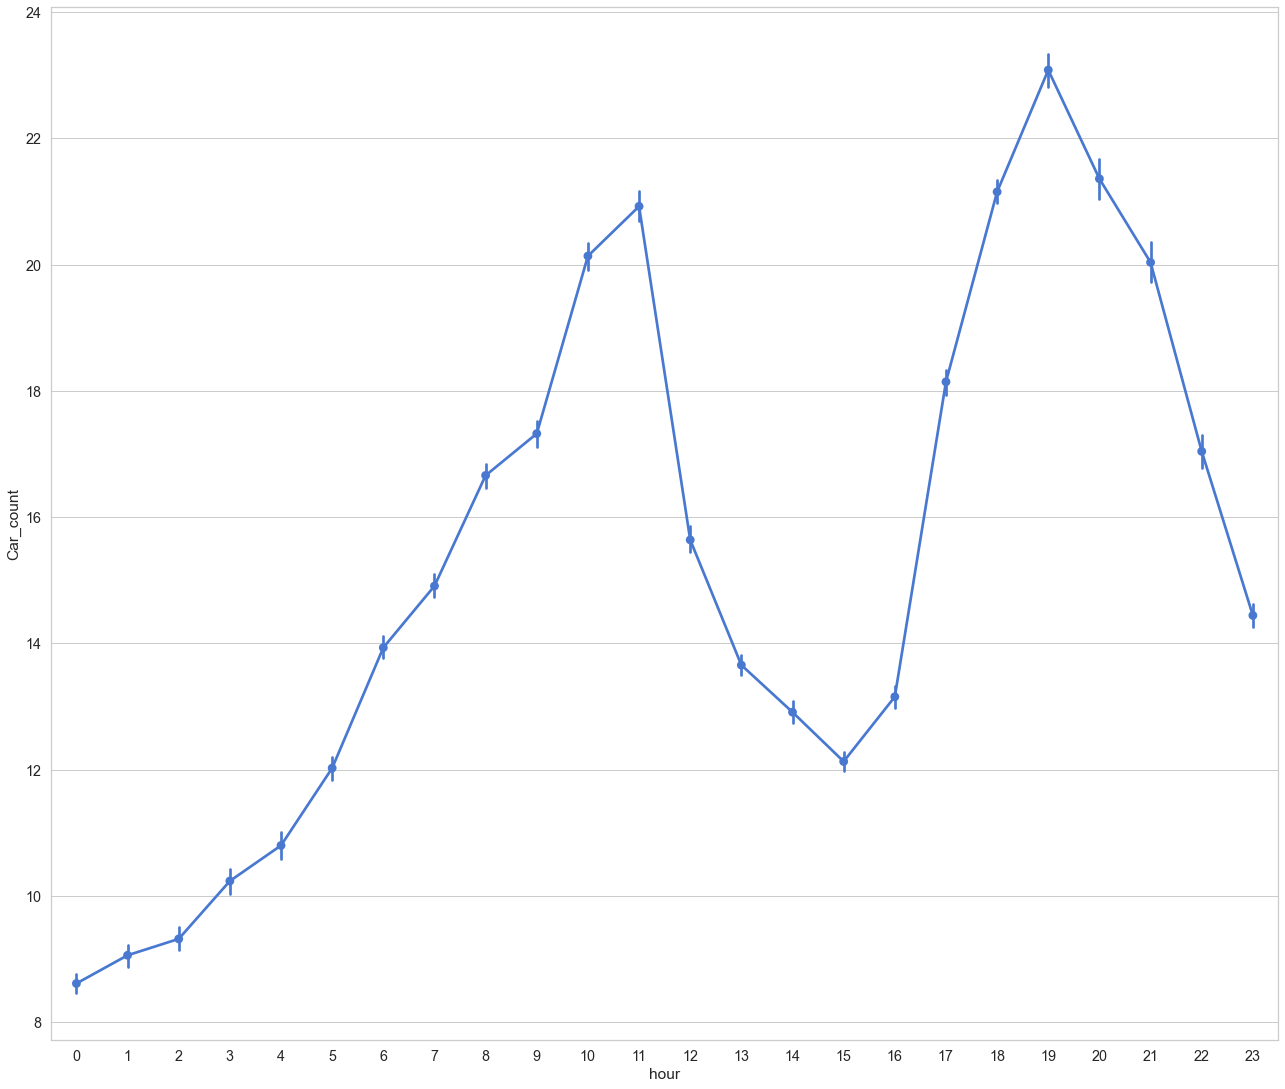

In [11]:
sns.pointplot(data=df, x='hour', y='Car_count');

In [12]:
train_size = int(len(df)*0.75)
test_size = len(df) - train_size
train,test = df.iloc[0:train_size], df.iloc[train_size: len(df)]

print(train.shape,test.shape)

(32400, 8) (10801, 8)


In [13]:
from sklearn.preprocessing import RobustScaler

cnt_transformer = RobustScaler()
cnt_transformer = cnt_transformer.fit(train[['Car_count']])
train['Car_count'] = cnt_transformer.transform(train[['Car_count']])
test['Car_count'] = cnt_transformer.transform(test[['Car_count']])
def create_dataset(X,y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

D:\anaconda\envs\tfenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\envs\tfenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
TIME_STEPS = 1440

X_train, y_train = create_dataset(train, train.Car_count, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.Car_count, time_steps=TIME_STEPS)

In [26]:
print(X_train.shape,y_train.shape)

(30960, 1440, 8) (30960,)


In [27]:
print(X_test.shape,y_test.shape)

(9361, 1440, 8) (9361,)


In [34]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=32, input_shape = (X_train.shape[1],X_train.shape[2]))))
model.add(keras.layers.Dense(units=64))
model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(units=1))

In [35]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
history = model.fit(
        X_train, y_train,
        epochs = 10,
        batch_size = 64,
        validation_split = 0.25,
        shuffle=False)

Epoch 1/10
363/363 [==============================] - 49s 136ms/step - loss: 0.7591 - val_loss: 0.6337
Epoch 2/10
 10/363 [..............................] - ETA: 36s - loss: 0.5780

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [21]:
model.save('LSTMv2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: LSTMv1\assets


In [22]:
y_pred = model.predict(X_test)

In [23]:
y_train_inv =cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv =cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

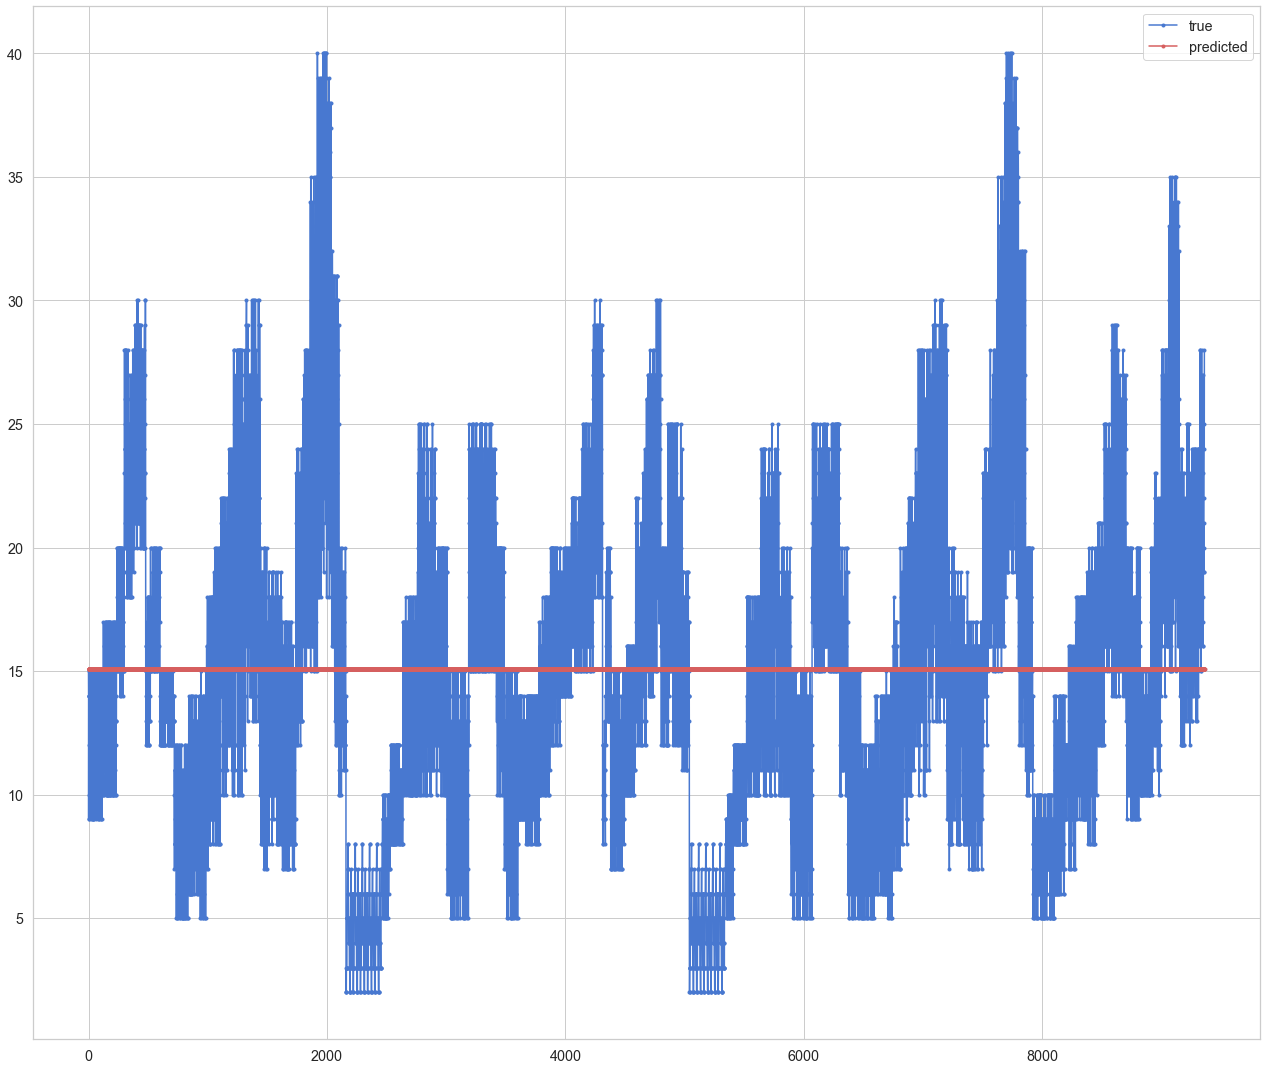

In [24]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r',marker='.', label='predicted')
plt.legend();